### Programming Assignment 5
# **Linear Regression**

AJ Dave A. Obis and Juan Francis C. Tuatis

## Import the libraries to be used


In [128]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# **General Guidelines**
## 1. Load and perform exploratory data analysis

In [129]:
data = pd.read_csv("cyber_attacks(in).csv")

# Transform the data to DataFrame
data_df = pd.DataFrame(data)

# Print the first few rows of the DataFrame
data_df.head()


,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


### Check the Dataset Contents

In [130]:
# Number of rows and columns in the DataFrame
print("Number of rows: ", data_df.shape[0])
print("Number of columns: ", data_df.shape[1])

Number of rows:  10000
Number of columns:  7


In [131]:
# Check if there are missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values:\n", + missing_values)

Missing values:
 protocol_type        0
duration           500
src_bytes          500
dst_bytes          500
num_packets          0
num_connections      0
attack_type          0
dtype: int64


Looking at the distribution of the dataset with missing values,

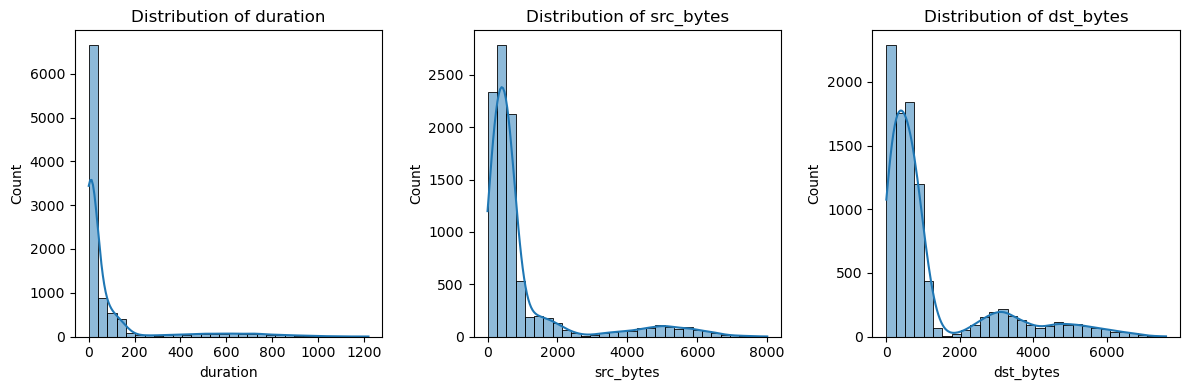

In [132]:
# Visualize distributions of affected numerical features
numerical_features = ['duration', 'src_bytes', 'dst_bytes']

# Plot histograms for missing value analysis
plt.figure(figsize=(12, 4))
for i, feature in enumerate(numerical_features):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data_df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

we can say that the data is right-skewed therefore highly variable.

### Attack Type Frequency

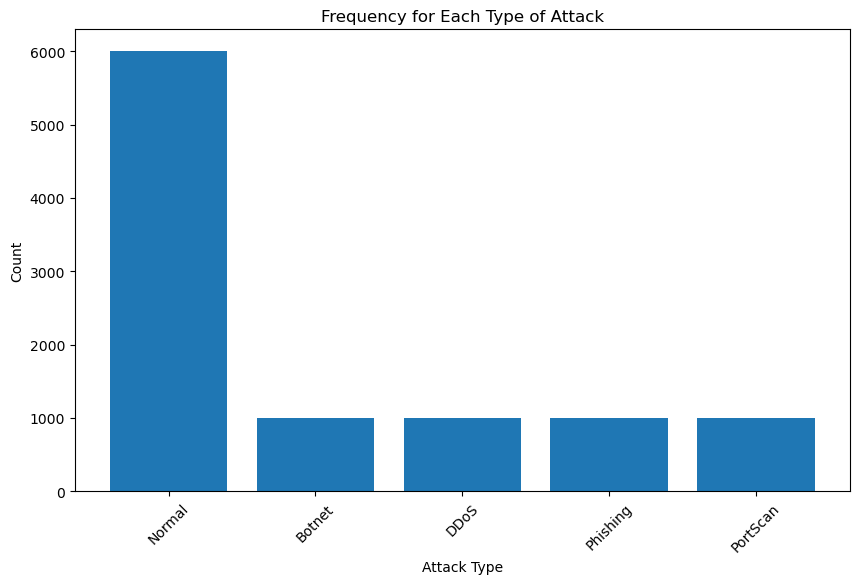

In [133]:
attack_counts = data_df['attack_type'].value_counts().reset_index()
attack_counts.columns = ['attack_type', 'count']

# Plot the attack counts
plt.figure(figsize=(10,6))
plt.bar(attack_counts['attack_type'], attack_counts['count'])

plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title('Frequency for Each Type of Attack')

plt.xticks(rotation=45)
plt.show()

### 

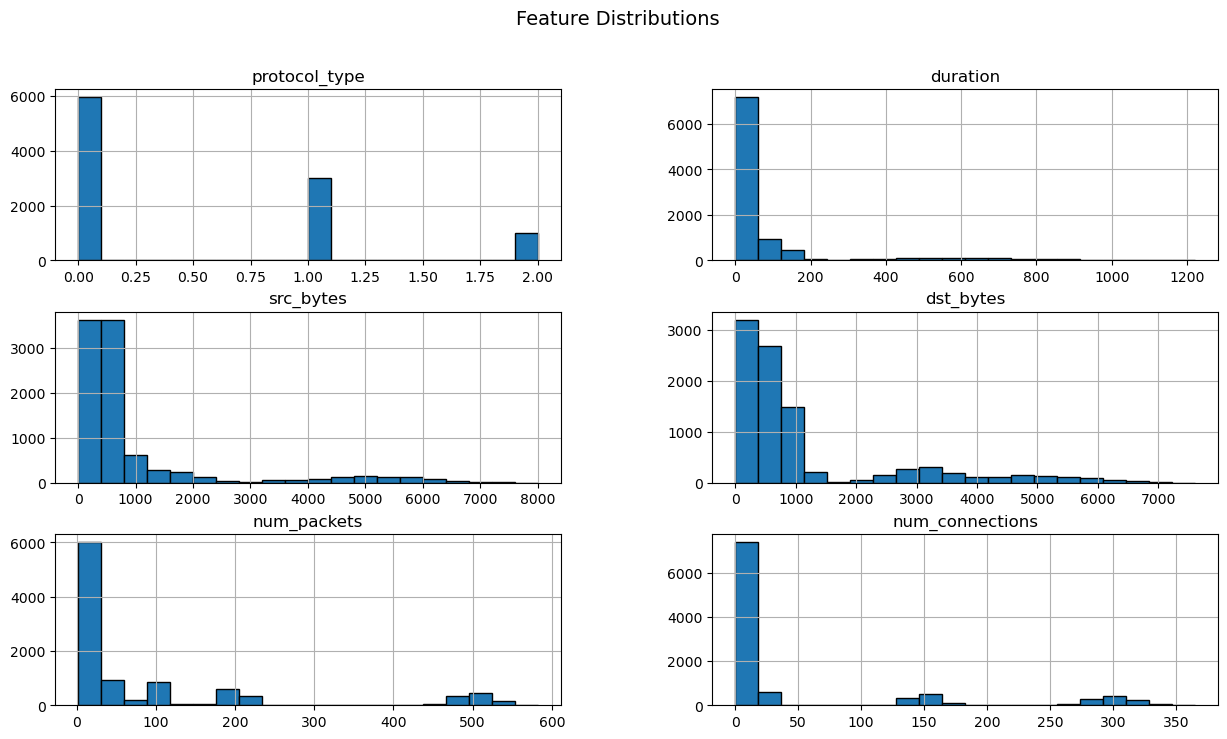

In [134]:
data_df.hist(figsize=(15, 8), bins=20, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

## 2. Perform data preprocessing.

### Handling missing values
To address the missing values from our EDA, we implemented median imputation which is effective for highly variable dataset and extreme values to avoid distortion

In [135]:
# Apply median imputation
imputer = SimpleImputer(strategy="median")
data_df[['duration', 'src_bytes', 'dst_bytes']] = imputer.fit_transform(data_df[['duration', 'src_bytes', 'dst_bytes']])

# show head
data_df.head()

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,7.121187,500.910972,598.294521,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


In [136]:
# Check if there are still missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values:\n", + missing_values)

Missing values:
 protocol_type      0
duration           0
src_bytes          0
dst_bytes          0
num_packets        0
num_connections    0
attack_type        0
dtype: int64


### Encoding categorical variable/feature (eg. protocol_type)

In [137]:
# Display the unique values in the categorical column
print("Unique values in protocol_type:", data_df['protocol_type'].unique())

# Perform one-hot encoding on the protocol_type column
data_df = pd.get_dummies(data_df, columns=['protocol_type'], drop_first=True)

# Display the first few rows of the encoded dataset
print("\nDataset after one-hot encoding:")
print(data_df.head())

Unique values in protocol_type: [1 0 2]

Dataset after one-hot encoding:
    duration    src_bytes   dst_bytes  num_packets  num_connections  \
0  43.418651  1701.411601  201.794741           42               15   
1   8.587924   409.971403  710.745376           17                6   
2   4.386891   418.478693  559.457816           17                5   
3   7.121187   500.910972  598.294521           11                3   
4   1.061892   494.253699  572.459614           11                3   

  attack_type  protocol_type_1  protocol_type_2  
0      Botnet             True            False  
1      Normal             True            False  
2      Normal             True            False  
3      Normal            False            False  
4      Normal            False            False  


### Handle class imbalance

In [138]:
print(data_df['attack_type'].value_counts())

attack_type
Normal      6000
Botnet      1000
DDoS        1000
Phishing    1000
PortScan    1000
Name: count, dtype: int64


In [139]:
# Check if there are still missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values:\n", + missing_values)

Missing values:
 duration           0
src_bytes          0
dst_bytes          0
num_packets        0
num_connections    0
attack_type        0
protocol_type_1    0
protocol_type_2    0
dtype: int64


In [141]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

#* Label Encoding on the attack_type column
enc = LabelEncoder()
data['attack_type'] = enc.fit_transform(data['attack_type'])
display(data.head())

#* For future purposes, return original labels
#! IMPORTANT: Run the `Load and Perform EDA` every time before running this code block. Failure to do so
#! will return the incorrect label encodings.

label_mapping = {index: class_label for index, class_label in enumerate(enc.classes_)}
print(label_mapping)

,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,0
1,1,8.587924,409.971403,710.745376,17,6,2
2,1,4.386891,418.478693,559.457816,17,5,2
3,0,NaN,NaN,NaN,11,3,2
4,0,1.061892,494.253699,572.459614,11,3,2


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


### Spliting the Train and Test Data
Split the data into training (70%) and testing (30%) sets.

In [ ]:
from sklearn.utils import resample 
#* For resampling of minority class
X,y = data.drop('attack_type',axis=1) , data['attack_type']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y, random_state=11)

train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['attack_type'] == 2]
minority_classes = train_data[train_data['attack_type'] != 2]

# Oversample the minority classes
minority_upsampled = resample(
    minority_classes,
    replace=True,  # Sample with replacement
    n_samples=len(majority_class)*4,  # Match the number of samples in the majority class
    random_state=11
)

# Combine the upsampled minority classes with the majority class
balanced_data = pd.concat([majority_class, minority_upsampled])

# Shuffle the dataset to ensure randomness
balanced_data = balanced_data.sample(frac=1, random_state=11).reset_index(drop=True)

# Separate features and labels again
X_train_resampled = balanced_data.drop(columns=['attack_type'])
y_train_resampled = balanced_data['attack_type']

#* Pipeline: Imputation using SimpleImputer on median, then pass to RandomForestClassifier with class_weight='balanced'
clf = make_pipeline(SimpleImputer(strategy='median'),RandomForestClassifier(n_estimators=3,class_weight='balanced',random_state=30,max_depth=3))
clf.fit(X_train_resampled,y_train_resampled)
y_pred = clf.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy Score: {balanced_acc:.4f}")


,precision,recall,f1-score,support
0,0.931677,1.000000,0.964630,300.000000
1,1.000000,1.000000,1.000000,300.000000
2,1.000000,0.999444,0.999722,1800.000000
3,1.000000,0.930000,0.963731,300.000000
4,1.000000,1.000000,1.000000,300.000000
accuracy,0.992667,0.992667,0.992667,0.992667
macro avg,0.986335,0.985889,0.985617,3000.000000
weighted avg,0.993168,0.992667,0.992669,3000.000000


Balanced Accuracy Score: 0.9859


TypeError: can only concatenate str (not "numpy.int64") to str

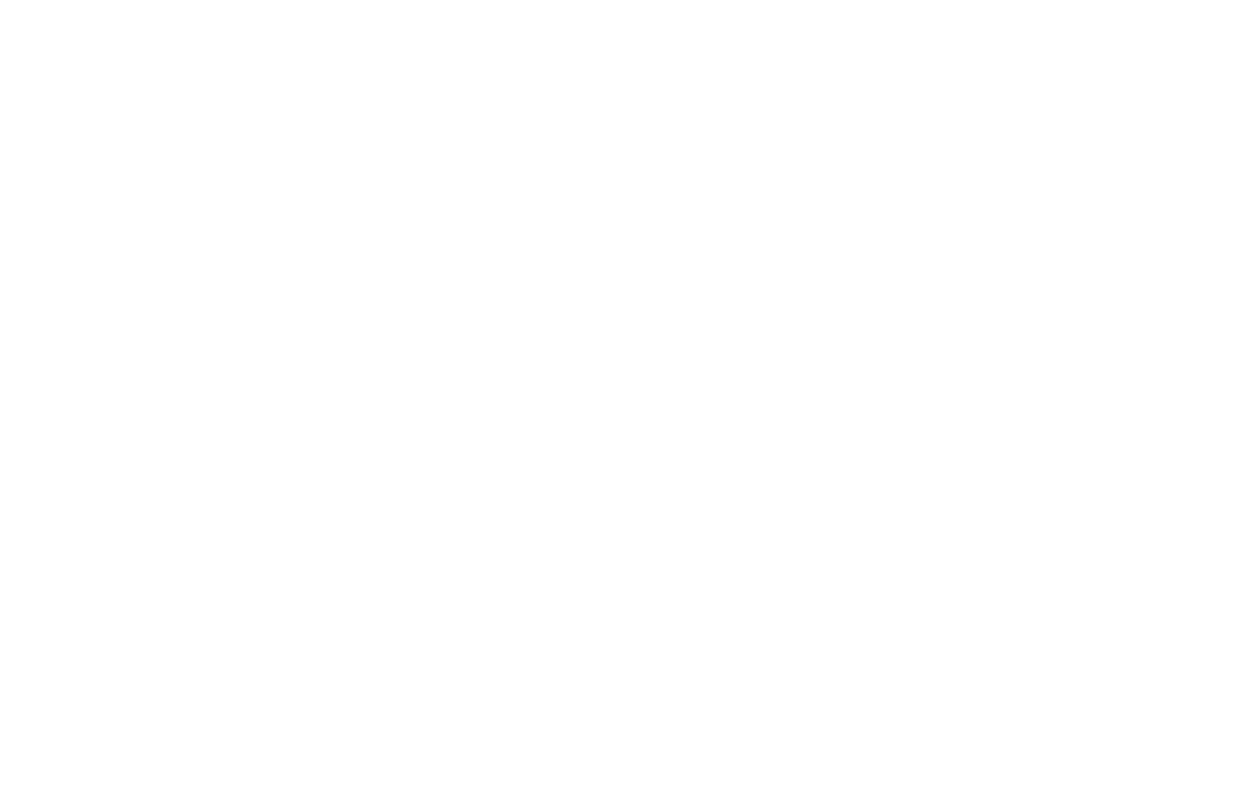

In [ ]:
# Visualize one tree
# Step 1: Extract the RandomForestClassifier from the pipeline
rf_classifier = clf.named_steps['randomforestclassifier']
# Step 2: Access the first tree from the RandomForestClassifier
estimator = rf_classifier.estimators_[0]  # Choosing the first tree

# Step 3: Visualize the tree
plt.figure(figsize=(16, 10))
plot_tree(
    decision_tree=estimator,  # Pass the estimator directly
    feature_names=data.columns.drop('attack_type'),  # Feature names
    class_names=list(label_mapping.values()),  # Class names
    filled=True  # Fill nodes with colors
)
plt.title('Visualization of a Single Decision Tree from Random Forest')
plt.show()

### Handle class imbalance
Looking at the distribution of the attack_type feature and its classes from our EDA, we can see that it is skewed giving favor to the "Normal" class. This could lead to a biased model. To solve this we can use the 'class_weight' parameter

In [ ]:
model = RandomForestClassifier(
    n_estimators=100,   # Reduce from 800 to 200
    max_depth=8,       # Reduce from 20 to 12
    min_samples_split=10,  # Prevents too many splits
    min_samples_leaf=5,    # Ensures each leaf has enough data
    class_weight="balanced_subsample",  # Better class balancing
    random_state=42
)
model.fit(X_train_resampled, y_train_resampled)

from sklearn.model_selection import cross_val_score

# Make predictions
scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

print("Train Accuracy:", model.score(X_train_resampled, y_train_resampled))
print("Test Accuracy:", model.score(X_test, y_test))  # Should not be 100%

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0
Train Accuracy: 1.0
Test Accuracy: 1.0


In [ ]:
# Train Random Forest with class weighting
model = RandomForestClassifier(
    n_estimators=300, 
    max_depth=12, 
    min_samples_split=5,
    min_samples_leaf=3,
    class_weight='balanced',
    random_state=42)
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [ ]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      Botnet       1.00      1.00      1.00       314
        DDoS       1.00      1.00      1.00       300
      Normal       1.00      1.00      1.00      1781
    Phishing       1.00      1.00      1.00       289
    PortScan       1.00      1.00      1.00       316

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000

